# The Data:
https://www.kaggle.com/c/nlp-getting-started/overview

# Desciption:
<p>In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.</p>

# Contents

[1. Imports](#1)
<br></br>
[2. EDA](#2)
<br></br>
[3. Data PreProcessing](#3)
<br></br>
[4. Creating and Trening a Model](#4)
<br></br>
[5. Make and Export Predictions](#5)

<span id = "1"></span>
# Imports

In [283]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import json
import re
import string

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

sns.set_style('darkgrid')

In [2]:
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [284]:
df = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

<span id = "2"></span>
# EDA

In [285]:
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


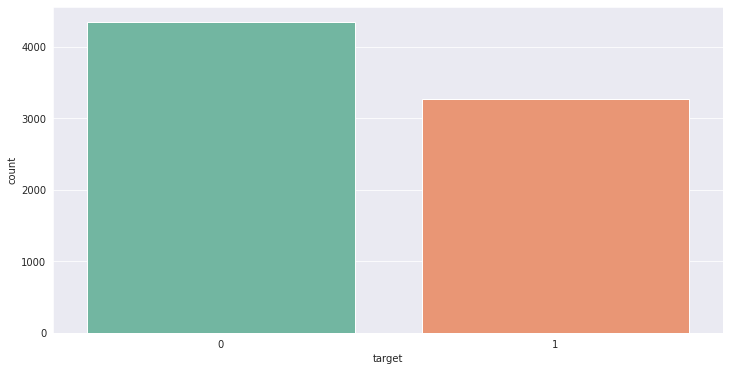

In [287]:
# Countplot of target column
plt.figure(figsize=(12,6))
sns.countplot(x = 'target', data = df, palette="Set2")

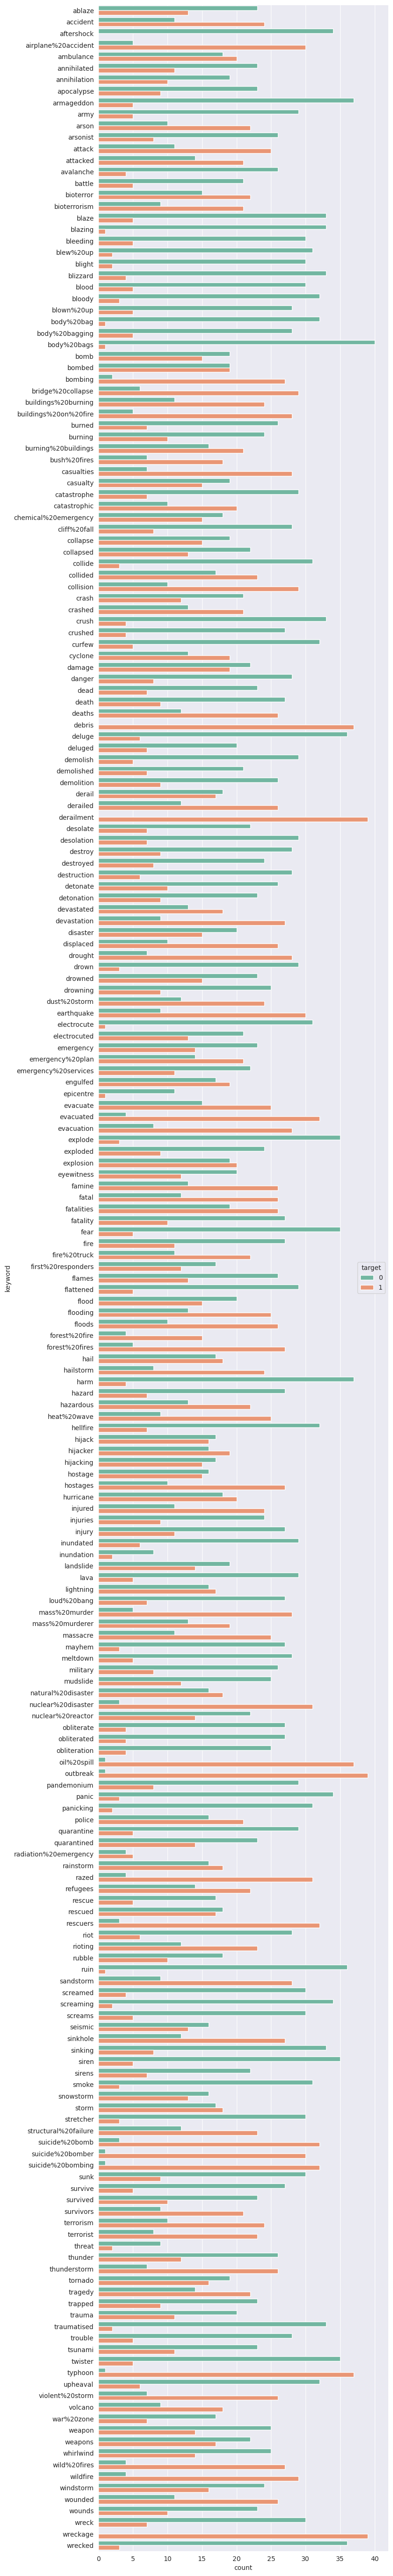

In [288]:
# Check the keywords and their appearances, taking into account the target
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df['keyword'], hue=df['target'], palette="Set2")

In [289]:
# Add new column 'text_len': Text length
df['text_len'] = df['text'].map(len)
df.head(3)

,id,keyword,location,text,target,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133


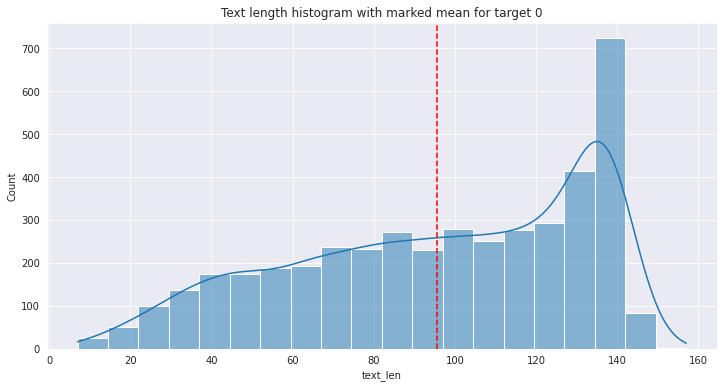

In [290]:
# Histogram of text length for target = 0
plt.figure(figsize=(12,6))

g = sns.histplot(data = df[df['target'] == 0], 
             x = 'text_len', kde = True, palette='Set2').set_title("Text length histogram with marked mean for target 0")

g = plt.axvline(df[df['target'] == 0].text_len.mean(), 
                color='r', linestyle = '--')

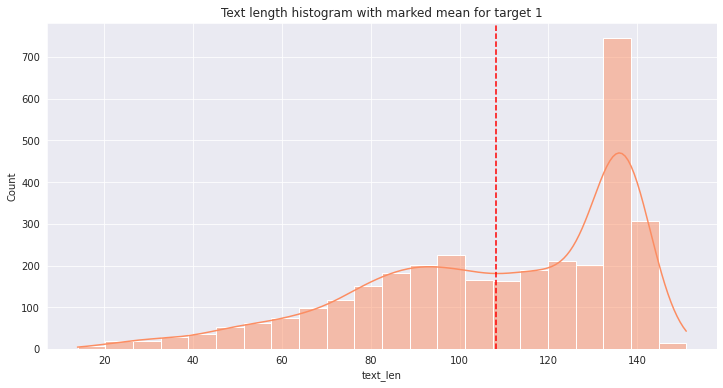

In [291]:
# Histogram of text length for target 1
plt.figure(figsize=(12,6))

g = sns.histplot(data = df[df['target'] == 1], 
             x = 'text_len', kde = True, color='#fc8d62').set_title("Text length histogram with marked mean for target 1")

g = plt.axvline(df[df['target'] == 1].text_len.mean(), 
                color='r', linestyle = '--')

<span id = "3"></span>
# Data PreProcessing

In [292]:
# List of stopwords
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [293]:
# Define functions which will help clean the text

####################################################################################
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

####################################################################################
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

####################################################################################
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

####################################################################################
# Main func
def clean_sentences(sentences):
    '''
    Make text lowercase, remove text in square brackets, 
    remove punctuation, remove words containing numbers,
    remove url, html, and emoji.
    '''
    cln_sentences = []
    for text in sentences:
      text = text.lower()
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
      text = re.sub('\w*\d\w*', '', text)
      ###
      text = remove_url(text)
      text = remove_html(text)
      text = remove_emoji(text)
      ###
      cln_sentences.append(text)
    return cln_sentences

In [294]:
### Prepare data

# Train 
train_sentences = []
train_labels = []

# append all text and label (target) to list
for ind, row in df.iterrows():
  train_labels.append(row['target'])

  sentence = row['text']
  # remove stopwords in sentences
  for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
      sentence = sentence.replace("  ", " ")
  train_sentences.append(sentence)

# Test
test_sentences = []

# append all text and label (target) to list
for ind, row in df2.iterrows():
  sentence = row['text']
  # remove stopwords in sentences
  for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
      sentence = sentence.replace("  ", " ")
  test_sentences.append(sentence)


## Use clean_sentences func
train_sentences = clean_sentences(train_sentences)
test_sentences = clean_sentences(test_sentences)

In [295]:
# Set parameters
vocab_size = 20000    # Max len of unique words
embedding_dim = 100   # Embedding dimension value
max_length = 110      # Max length of sentence
padding_type = 'post' # pad_sequences arg
trunc_type = 'post'   # trunc post
oov_tok = '<OOV>'     # Unknow words = <OOV>

In [296]:
# Tokenizing and padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(test_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [297]:
# Prepare labels for model
training_labels_final = np.array(train_labels)

# Check shapes
print(training_labels_final.shape)

(7613,)


In [298]:
# from google.colab import files
# uploaded = files.upload()

In [299]:
# GloVe
# Note this is the 100 dimension version of GloVe from Stanford
embeddings_index = {};
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

<span id = "4"></span>
# Creating and Trening a Model

In [300]:
# Create a Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(128, 2, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10

history = model.fit(train_padded, training_labels_final, epochs=num_epochs, verbose=2)

print("Training Complete")

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 110, 100)          2000100   
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 109, 128)          25728     
_________________________________________________________________
global_average_pooling1d_23  (None, 128)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 40)                5160      
_________________________________________________________________
dropout_95 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 20)                820       
_________________________________________________________________
dropout_96 (Dropout)         (None, 20)              

<span id = "5"></span>
# Make and Export Predictions

In [301]:
# Make predictions on test data
pred = model.predict_classes(validation_padded)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [302]:
# export predictions to csv file. 
results = pd.DataFrame(data = pred, columns = ['target'])
results = results.set_index(df2.id)
results.to_csv("results.csv", index = True, sep=',')
files.download("results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>